In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from analytics import merchant_stability, outlier_detection, unbranded_tagger

np.random.seed(42)

Importing plotly failed. Interactive plots will not work.


## Unbranded tagger

In [2]:
to_label = np.array([
    'large beer 0.5', 
    'beer bottle heineken 0.5', 
    'white wine 0.3',
    'beer heineken',
    'beer 0.0',
    'beer glass red',
    'red bull can'
])
unbranded = np.array([
    'small beer',
    'bottle large',
    'wine red',
    'white wine glass',
    'beer can',
    'wine bottle',
    'beer large',
    'bottle white',
    'bloody bull cocktail'
]) 

In [3]:
to_label_unbranded = unbranded_tagger.get_unbranded(
    to_label=to_label,
    unbranded=unbranded,
    tokens_to_exclude=['red', 'bull'],  # for brands comprised of common words 
    min_unbranded_rows=1,
)

In [4]:
print('Items labeled as "unbranded":\n')
for item in to_label[to_label_unbranded]:
    print(item)

Items labeled as "unbranded":

large beer 0.5
white wine 0.3
beer 0.0


## Merchant stability

In [5]:
example_daily_stats = pd.read_csv('daily_stats_example.csv')
example_daily_stats.head()

,Unnamed: 0,vendor,merchant,date,n_lines
0,0,A,1593,2017-01-02,52
1,1,A,1593,2017-01-04,54
2,2,A,1593,2017-01-05,18
3,3,A,1593,2017-01-06,286
4,4,A,1593,2017-01-07,400


In [6]:
example_stability = merchant_stability.get_merchant_stats(
    example_daily_stats, 
    stability_settings={
        'minimum_activity': 0.5,
        'maximum_volatility': 0.5,
        'maximum_gap': 50,  
    }
)
example_stability.head()

,vendor,merchant,merchant_id,lifespan,active_days,activity,volatility,longest_gap,n_lines,first_day,last_day,stable,churned
0,A,1593,532d9ef8703d0464891b76162c3df049,371,307,0.827493,0.211611,44,28950,2017-01-02,2018-01-07,False,True
1,A,2707,3aeaf1944a2b55c417c26673725d9794,442,441,0.997738,0.186825,1,22884,2018-01-19,2019-04-05,False,True
2,A,3280,a47253480f4fa37f04c4abfa94f889d0,660,487,0.737879,0.141764,16,35015,2017-01-03,2018-10-24,False,True
3,A,3842,4a77173ffcb2b99a653b80fad49be952,467,452,0.967880,0.059243,10,137411,2018-12-06,2020-03-16,True,False
4,A,4160,1ddb154631c7d0c4709d7f008b25b9a3,1080,991,0.917593,0.267192,26,50269,2017-05-03,2020-04-16,True,False


In [7]:
# This file can be later used for selecting stability thresholds in Stability settings Shiny app
example_stability.to_csv('merchant_stats_example.csv', index=False)

## Outlier detection

In [8]:
sample_merchant = example_daily_stats['merchant'].sample(1).values[0]
metadata = {
    'metric': 'n_lines', 
    'dimension': 'merchant', 
    'item': sample_merchant,
}

In [9]:
# Transforming into a Dataframe with observations for a single metric in column `y`
metric_data = (
    example_daily_stats
    .loc[lambda d: d['merchant'] == sample_merchant]
    .assign(**metadata)
    .rename(columns={'n_lines': 'y'})
)

In [10]:
metric_data

,Unnamed: 0,vendor,merchant,date,y,metric,dimension,item
19769,19769,B,6713,2018-11-16,52,n_lines,merchant,6713
19770,19770,B,6713,2018-11-17,32,n_lines,merchant,6713
19771,19771,B,6713,2018-11-19,4,n_lines,merchant,6713
19772,19772,B,6713,2018-11-20,1,n_lines,merchant,6713
19773,19773,B,6713,2018-11-21,5,n_lines,merchant,6713
...,...,...,...,...,...,...,...,...
20135,20135,B,6713,2020-03-12,26,n_lines,merchant,6713
20136,20136,B,6713,2020-03-13,19,n_lines,merchant,6713
20137,20137,B,6713,2020-03-15,24,n_lines,merchant,6713
20138,20138,B,6713,2020-03-16,4,n_lines,merchant,6713


In [11]:
training_data, test_data = outlier_detection.prepare(
    data=metric_data, 
    reference_date='2020-01-01',
    dates_to_exclude=[],
)

In [12]:
test_daterange = pd.DataFrame({
    'ds': pd.date_range(
        test_data['ds'].min(),
        test_data['ds'].max(),
    )
})

In [13]:
analyzer = outlier_detection.TimeSeriesAnalyzer(
    old_data=training_data,
    new_data=test_data,
    new_daterange=test_daterange,
    metadata=metadata,
)
analyzer.find_deviations()

Summary of results: 

In [14]:
analyzer.get_summary()

,metric,dimension,item,ok
0,n_lines,merchant,6713,False


Chart of actual values and predictions:

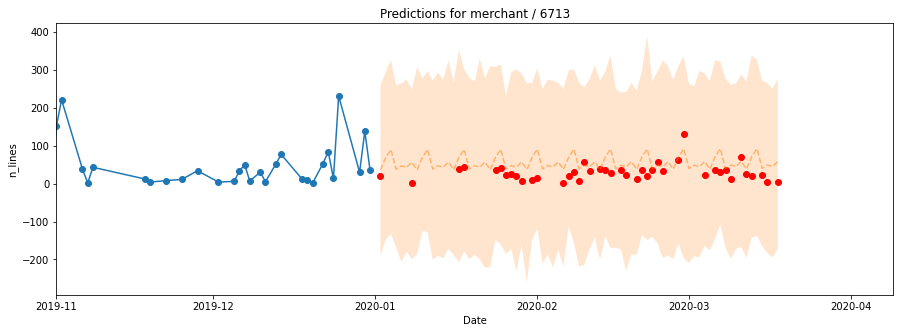

In [15]:
analyzer.make_chart();

Detail view of problematic dates:

In [16]:
analyzer.get_filtered_deviations()

,ds,metric,dimension,item,status
1,2020-01-03,n_lines,merchant,6713,missing
2,2020-01-04,n_lines,merchant,6713,missing
3,2020-01-05,n_lines,merchant,6713,missing
4,2020-01-06,n_lines,merchant,6713,missing
5,2020-01-07,n_lines,merchant,6713,missing
7,2020-01-09,n_lines,merchant,6713,missing
8,2020-01-10,n_lines,merchant,6713,missing
9,2020-01-11,n_lines,merchant,6713,missing
10,2020-01-12,n_lines,merchant,6713,missing
11,2020-01-13,n_lines,merchant,6713,missing
